# BLE Proximity Experiment - Random Forest Classifier
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
from pandas.plotting import scatter_matrix

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Replace 0 with Nan RSSI Values

In [3]:
def replace_features_nan(dataset):
    dataset['rssi_Value'] = dataset['rssi_Value'].replace(0,np.nan)
    dataset['rolling_mean_rssi'] = dataset['rolling_mean_rssi'].replace(0,np.nan)

### Initialize Dataset
Initialization of the data from the file

In [4]:
dataset = load_file('../../distance_proximity_experiments.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
replace_features_nan(dataset)
display(dataset)
display(dataset.shape)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-47,-47.000000,0-1 meters,0.0
1,0.0,0.0,-46,-46.500000,0-1 meters,0.0
2,0.0,0.0,-46,-46.333333,0-1 meters,0.0
3,0.0,0.0,-47,-46.500000,0-1 meters,0.0
4,0.0,0.0,-47,-46.600000,0-1 meters,0.0
...,...,...,...,...,...,...
12470,0.0,3.5,-87,-84.555556,3-4 meters,3.5
12471,0.0,3.5,-87,-84.684211,3-4 meters,3.5
12472,0.0,3.5,-87,-84.800000,3-4 meters,3.5
12473,0.0,3.5,-87,-84.904762,3-4 meters,3.5


(12475, 6)

### Initialize Test Set

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-50,-50.000000,0-1 meters,0.0
1,0.0,0.0,-50,-50.000000,0-1 meters,0.0
2,0.0,0.0,-53,-51.000000,0-1 meters,0.0
3,0.0,0.0,-51,-51.000000,0-1 meters,0.0
4,0.0,0.0,-53,-53.000000,0-1 meters,0.0
...,...,...,...,...,...,...
410,0.0,3.5,-86,-83.800000,3-4 meters,3.5
411,0.0,3.5,-88,-84.500000,3-4 meters,3.5
412,0.0,3.5,-84,-84.428571,3-4 meters,3.5
413,0.0,3.5,-83,-84.250000,3-4 meters,3.5


(415, 6)

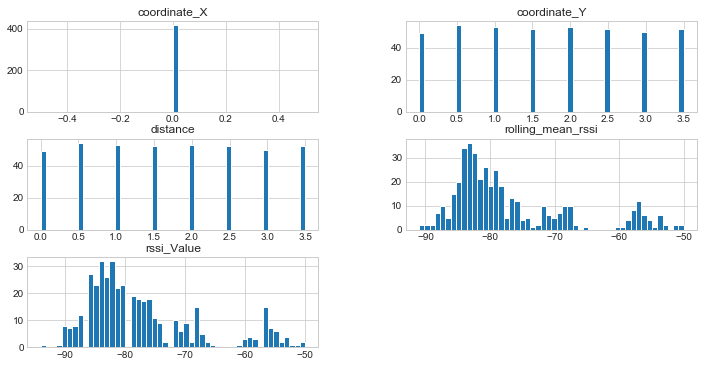

In [5]:
test_dataset = load_file('../../distance_proximity_experiments-checkpoint.csv')
positions = test_dataset['coordinate_Y']
test_dataset['distance'] = positions
replace_features_nan(test_dataset)
display(test_dataset)
display(test_dataset.shape)
test_dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (My Device)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-44,-44.000000,0-1 meters,0.0
1,0.0,0.0,-44,-44.000000,0-1 meters,0.0
2,0.0,0.0,-44,-44.000000,0-1 meters,0.0
3,0.0,0.0,-44,-44.000000,0-1 meters,0.0
4,0.0,0.0,-45,-44.200000,0-1 meters,0.0
...,...,...,...,...,...,...
2279,0.0,3.5,-84,-83.944444,3-4 meters,3.5
2280,0.0,3.5,-85,-84.000000,3-4 meters,3.5
2281,0.0,3.5,-85,-84.050000,3-4 meters,3.5
2282,0.0,3.5,-92,-84.428571,3-4 meters,3.5


(2284, 6)

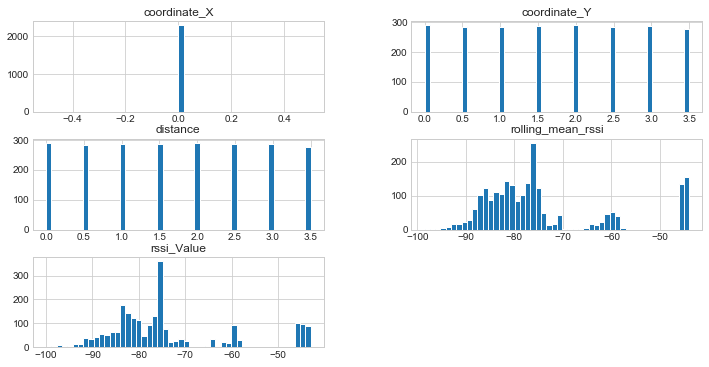

In [6]:
test_dataset_my_device = load_file('../../dataset_test.csv')
positions = test_dataset_my_device['coordinate_Y']
test_dataset_my_device['distance'] = positions
replace_features_nan(test_dataset_my_device)
display(test_dataset_my_device)
display(test_dataset_my_device.shape)
test_dataset_my_device.hist(bins=50,figsize=(12,6))
plt.show()

### Dataset Overall Info

In [7]:
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12475 entries, 0 to 12474
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   coordinate_X       12475 non-null  float64
 1   coordinate_Y       12475 non-null  float64
 2   rssi_Value         12475 non-null  int64  
 3   rolling_mean_rssi  12475 non-null  float64
 4   zone               12475 non-null  object 
 5   distance           12475 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 584.9+ KB


None

### File Overall Description
Usage of describe pandas function on the dataset

In [8]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
coordinate_X,12475.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.0
coordinate_Y,12475.0,1.728457,1.144743,0.0,0.5,1.500000,2.50,3.5
rssi_Value,12475.0,-73.416754,12.929039,-102.0,-82.0,-76.000000,-64.00,-45.0
rolling_mean_rssi,12475.0,-73.454044,12.766312,-98.5,-82.2,-76.285714,-63.75,-46.0
distance,12475.0,1.728457,1.144743,0.0,0.5,1.500000,2.50,3.5


### % of Missing Values

In [9]:
def compute_missing_values(dataset): 
    missing_values = dataset.isnull().sum()
    missing_values_dataset = pd.DataFrame(missing_values,columns=['Missing Values'])
    missing_percentage = (dataset.isnull().sum() / dataset.count())
    missing_percentage_dataset = pd.DataFrame(missing_percentage,columns=['% of Missing Values'])
    missing_dataset = missing_values_dataset.join(missing_percentage_dataset)
    display(missing_dataset)

In [10]:
compute_missing_values(dataset)

,Missing Values,% of Missing Values
coordinate_X,0,0.0
coordinate_Y,0,0.0
rssi_Value,0,0.0
rolling_mean_rssi,0,0.0
zone,0,0.0
distance,0,0.0


### Overall Histogram of dataset atributes

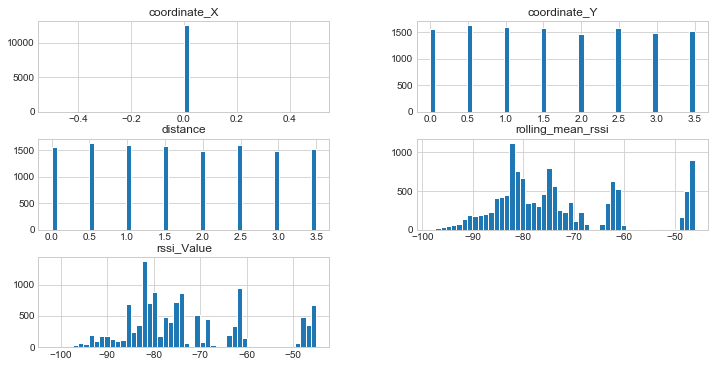

In [11]:
dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Target Attribute - Zone
Graphical display of the zones scanned in the experiment

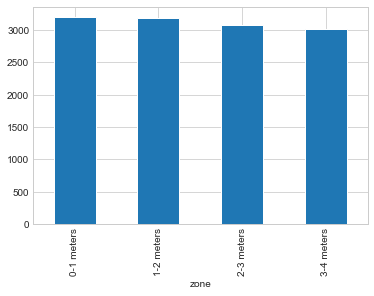

In [12]:
reference_points = dataset.groupby(['zone'])
reference_points.size().plot(kind="bar")

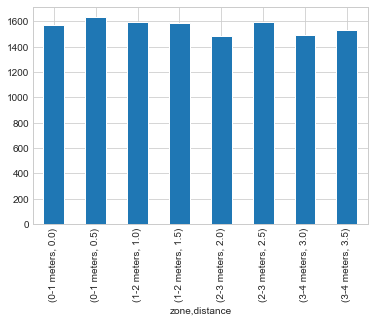

In [13]:
reference_points = dataset.groupby(['zone','distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

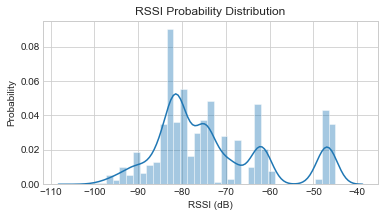

In [14]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

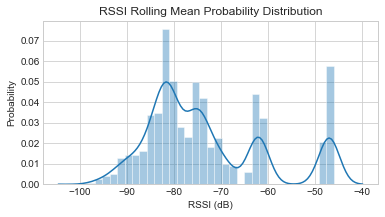

In [15]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

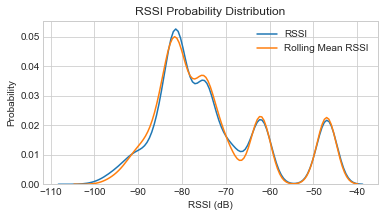

In [16]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Correlations
Check how much each attribute collerates with each other. Valures frange from -1 to 1. Close to 1 means a strong positive correlation.

In [17]:
def compute_correlations(dataset):
    corr_matrix = dataset.corr()
    display(corr_matrix)
    display(corr_matrix['distance'].sort_values(ascending=False))
    attributes = ["distance","rssi_Value", "rolling_mean_rssi"]
    scatter_matrix(dataset[attributes], figsize=(12, 8))

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,distance
coordinate_X,NaN,NaN,NaN,NaN,NaN
coordinate_Y,NaN,1.000000,-0.864615,-0.873980,1.000000
rssi_Value,NaN,-0.864615,1.000000,0.981441,-0.864615
rolling_mean_rssi,NaN,-0.873980,0.981441,1.000000,-0.873980
distance,NaN,1.000000,-0.864615,-0.873980,1.000000


distance             1.000000
coordinate_Y         1.000000
rssi_Value          -0.864615
rolling_mean_rssi   -0.873980
coordinate_X              NaN
Name: distance, dtype: float64

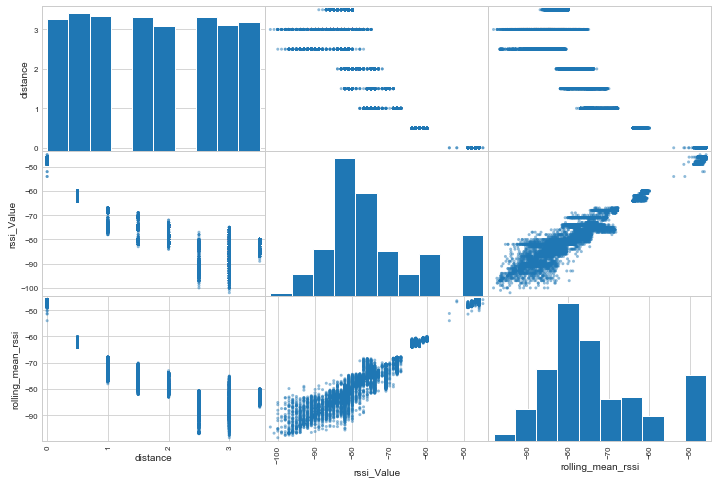

In [18]:
compute_correlations(dataset)

### Data Cleaning
Fill in missing values and fix/remove outliers

In [19]:
def compute_data_cleaning(dataset,feature):
    nan_filler = dataset[feature].min()*1.010
    dataset[feature] = dataset[feature].fillna(nan_filler) # Fill missing values

In [20]:
compute_data_cleaning(dataset,'rssi_Value')
compute_data_cleaning(dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset,'rssi_Value')
compute_data_cleaning(test_dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_my_device,'rssi_Value')
compute_data_cleaning(test_dataset_my_device,'rolling_mean_rssi')

### Dealing with Categorical Data
Using Hot-Encoder or Label Encoder to convert text/categorical data into numerical data. ML algorithms prefer it

In [21]:
label_encoder = LabelEncoder()
def compute_encoder(categorical_data,flag):
    if flag == 0:
        labels = label_encoder.fit_transform(categorical_data)
    else:
        labels = label_encoder.transform(categorical_data)
    return labels

In [22]:
categorical_zone = dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
zone_changed = compute_encoder(categorical_zone,0)
print("After One Hot Encoder")
dataset['labels'] = zone_changed
train_Y = dataset['labels'].values.reshape(-1,1)
display(train_Y)

Previous Categorical Data


,zone
0,0-1 meters
1,0-1 meters
2,0-1 meters
3,0-1 meters
4,0-1 meters
...,...
12470,3-4 meters
12471,3-4 meters
12472,3-4 meters
12473,3-4 meters


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[0],
       [0],
       [0],
       ...,
       [3],
       [3],
       [3]])

In [23]:
categorical_zone = test_dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset['labels'] = test_changed
test_Y = test_dataset['labels'].values.reshape(-1,1)
display(test_Y.shape)

Previous Categorical Data


,zone
0,0-1 meters
1,0-1 meters
2,0-1 meters
3,0-1 meters
4,0-1 meters
...,...
410,3-4 meters
411,3-4 meters
412,3-4 meters
413,3-4 meters


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(415, 1)

In [24]:
categorical_zone = test_dataset_my_device[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_my_device['labels'] = test_changed
test_Y_my_device = test_dataset_my_device['labels'].values.reshape(-1,1)
display(test_Y_my_device.shape)

Previous Categorical Data


,zone
0,0-1 meters
1,0-1 meters
2,0-1 meters
3,0-1 meters
4,0-1 meters
...,...
2279,3-4 meters
2280,3-4 meters
2281,3-4 meters
2282,3-4 meters


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(2284, 1)

### Initialize Training Data
Training Data intialization for predictions purposes

In [25]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values.reshape(-1,1)
display(train_X_rssi.shape)
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(train_X_rolling_mean.shape)
combination_features_X = dataset[['rssi_Value','rolling_mean_rssi']]
display(combination_features_X.shape)

(12475, 1)

(12475, 1)

(12475, 2)

In [26]:
data_plot_means = dataset.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
0-1 meters,-54.656250,-54.714171
1-2 meters,-73.941824,-73.986266
2-3 meters,-81.840872,-81.883638
3-4 meters,-84.163468,-84.165817


### Plot Training Data
Graphical Display of the observations in the dataset

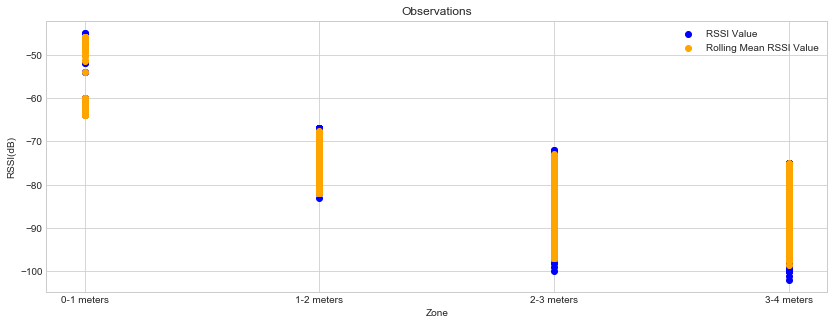

In [27]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Test Data

In [28]:
test_X_rssi = pd.DataFrame(test_dataset['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi.shape)
test_X_rolling_mean = pd.DataFrame(test_dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean.shape)
test_combination_features_X = test_dataset[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X.shape)

(415, 1)

(415, 1)

(415, 2)

In [29]:
data_plot_means = test_dataset.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
0-1 meters,-63.223301,-63.123000
1-2 meters,-79.533333,-79.841372
2-3 meters,-82.171429,-81.838530
3-4 meters,-84.215686,-83.930766


In [30]:
test_X_rssi_my_device = pd.DataFrame(test_dataset_my_device['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_my_device.shape)
test_X_rolling_mean_my_device = pd.DataFrame(test_dataset_my_device['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_my_device.shape)
test_combination_features_X_my_device = test_dataset_my_device[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_my_device.shape)

(2284, 1)

(2284, 1)

(2284, 2)

In [31]:
data_plot_means = test_dataset_my_device.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
0-1 meters,-55.246503,-55.259603
1-2 meters,-78.954545,-79.459584
2-3 meters,-77.871080,-77.982160
3-4 meters,-85.335689,-85.247963


### Plot Test Data

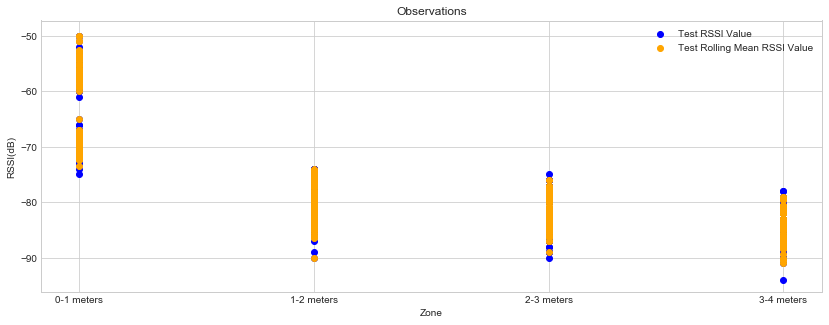

In [32]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset['zone'],test_dataset['rssi_Value'],label='Test RSSI Value',color='blue')
plt.scatter(test_dataset['zone'],test_dataset['rolling_mean_rssi'],label='Test Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

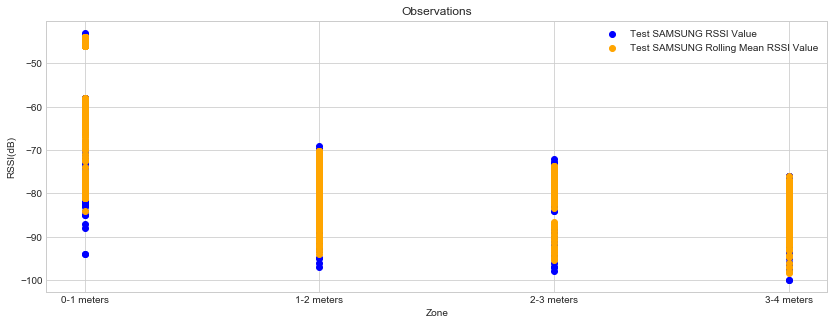

In [33]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_my_device['zone'],test_dataset_my_device['rssi_Value'],label='Test SAMSUNG RSSI Value',color='blue')
plt.scatter(test_dataset_my_device['zone'],test_dataset_my_device['rolling_mean_rssi'],label='Test SAMSUNG Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Hyperparameters for tunning

In [34]:
rf_basic = RandomForestClassifier()
print("DEFAULT HYPERPARAMETERS")
default_params = rf_basic.get_params()
display(pd.DataFrame(default_params,index=[1])) 
#Preprocessing options
scaler = [StandardScaler(),MaxAbsScaler(),MinMaxScaler(),None]
# Number of trees in random forest
initial_linespace = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] 
n_estimators = [10,100] + initial_linespace
# Criterion to consider at every split
criterion_metric = ['gini','entropy']
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'rf__n_estimators': n_estimators,
               'rf__criterion': criterion_metric,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap}
print(random_grid)

DEFAULT HYPERPARAMETERS


,bootstrap,ccp_alpha,class_weight,criterion,max_depth,max_features,max_leaf_nodes,max_samples,min_impurity_decrease,min_impurity_split,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,n_jobs,oob_score,random_state,verbose,warm_start
1,True,0.0,None,gini,None,auto,None,None,0.0,None,1,2,0.0,100,None,False,None,0,False


{'rf__n_estimators': [10, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'rf__criterion': ['gini', 'entropy'], 'rf__max_features': ['auto', 'sqrt', 'log2'], 'rf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'rf__min_samples_split': [2, 5, 10], 'rf__min_samples_leaf': [1, 2, 4], 'rf__bootstrap': [True, False]}


### Statistics Output Format
Structure of the statistical output of each call to the machine learning algorithm

In [35]:
def structure_data(data,precision,accuracy,f1score):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    precision = precision
    accuracy = accuracy
    f1score = f1score
    statistical_results = [mae,mse,rsme,precision,accuracy,f1score]
    return statistical_results

### Feature Selection
Check strength of features using ensemble algorithm Random Forest

Feature Selection Computation


array([0.4260187, 0.5739813])

rolling_mean_rssi    0.573981
rssi_Value           0.426019
dtype: float64

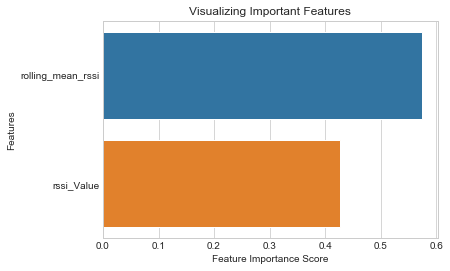

In [36]:
print("Feature Selection Computation")
random_forest_estimator = RandomForestClassifier()
main_estimator = make_pipeline(StandardScaler(),random_forest_estimator)
main_estimator.fit(combination_features_X,train_Y.ravel())
display(random_forest_estimator.feature_importances_)
feature_imp = pd.Series(random_forest_estimator.feature_importances_,index=combination_features_X.columns).sort_values(ascending=False)
display(feature_imp)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Model Training and Evaluation - RF Classification Model

In [37]:
def compute_RF_Classification(flag=0,
                              trainX_data = None, trainY_data = None,
                              testX_data = None,testY_data = None, 
                              scaler = None,cross_validation = None,
                              n_estimators_parameter = 100, criterion_parameter = 'gini',
                              max_depth_parameter = None,min_samples_split_parameter = 2,
                              min_samples_leaf_parameter = 1,max_features_parameter = 'auto',
                              bootstrap_parameter = True, random_state_parameter = 6):
    random_forest_estimator = RandomForestClassifier(n_estimators=n_estimators_parameter,criterion=criterion_parameter,
                                                    max_features=max_features_parameter,max_depth=max_depth_parameter,
                                                    min_samples_leaf=min_samples_leaf_parameter,min_samples_split=min_samples_split_parameter,
                                                    bootstrap=bootstrap_parameter,random_state=random_state_parameter)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,random_forest_estimator)
    else:
        main_estimator = random_forest_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    else:
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    statistical_array = list()
    statistics = pd.DataFrame(report).transpose()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    if flag == 1:
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
    error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
    result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
    return structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())

#### Check Training model with no cross validation

Confusion Matrix:
[[3200    0    0    0]
 [   0 2665   50  465]
 [   0  564 1946  563]
 [   0  108  896 2018]]


,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,3200.000000
1,0.798622,0.838050,0.817861,3180.000000
2,0.672891,0.633257,0.652473,3073.000000
3,0.662508,0.667770,0.665129,3022.000000
accuracy,0.787896,0.787896,0.787896,0.787896
macro avg,0.783505,0.784769,0.783866,12475.000000
weighted avg,0.786333,0.787896,0.786843,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,3,3
12471,3,3
12472,3,3
12473,3,3


Confusion Matrix:
[[3200    0    0    0]
 [   0 2842  202  136]
 [   0  424 1957  692]
 [   0   82  592 2348]]


,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,3200.000000
1,0.848865,0.893711,0.870711,3180.000000
2,0.711378,0.636837,0.672047,3073.000000
3,0.739295,0.776969,0.757664,3022.000000
accuracy,0.829419,0.829419,0.829419,0.829419
macro avg,0.824884,0.826879,0.825105,12475.000000
weighted avg,0.827223,0.829419,0.827553,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,3,3
12471,3,3
12472,3,3
12473,3,3


Confusion Matrix:
[[3200    0    0    0]
 [   0 2948  129  103]
 [   0  194 2687  192]
 [   0   62  334 2626]]


,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,3200.000000
1,0.920100,0.927044,0.923559,3180.000000
2,0.853016,0.874390,0.863571,3073.000000
3,0.899007,0.868961,0.883729,3022.000000
accuracy,0.918717,0.918717,0.918717,0.918717
macro avg,0.918031,0.917599,0.917715,12475.000000
weighted avg,0.918961,0.918717,0.918741,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,3,3
12471,3,3
12472,3,3
12473,3,3


,mae,mse,rmse,precision,accuracy,f1-score,type
2,0.081283,0.081283,0.285101,0.918262,0.918717,0.918005,Both
1,0.170581,0.170581,0.413015,0.825866,0.829419,0.826071,Rolling Mean RSSI
0,0.212104,0.212104,0.460548,0.784536,0.787896,0.784867,RSSI Only


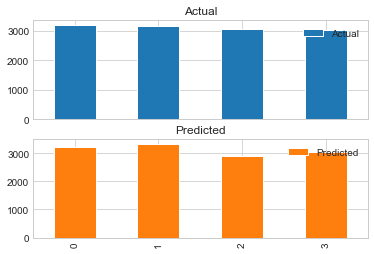

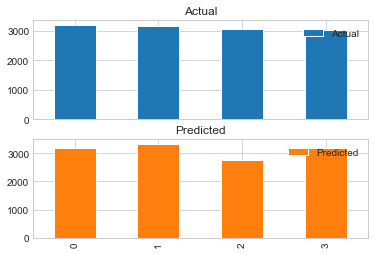

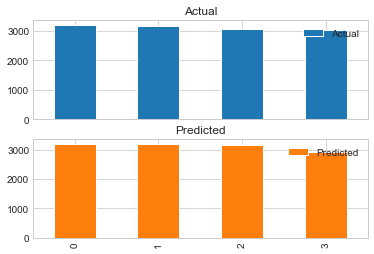

In [38]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    result = compute_RF_Classification(flag=1,trainX_data=trainX_data,trainY_data=train_Y.ravel(),
                                   testX_data=trainX_data,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))

#### Experiment - KNN with StratifiedKFold
Experiment using cross validation approach of StratifiedKFold

,mae,mse,rmse,precision,accuracy,f1-score,folds,type
11,0.226453,0.226453,0.475871,0.769677,0.773547,0.770017,5,Both
10,0.238798,0.238798,0.488669,0.758212,0.761202,0.758091,4,Both
9,0.249860,0.249860,0.499860,0.744752,0.750140,0.745669,3,Both
1,0.259880,0.259880,0.509784,0.735718,0.740120,0.735770,3,RSSI Only
3,0.262365,0.262365,0.512216,0.732199,0.737635,0.733224,5,RSSI Only
2,0.274709,0.274709,0.524127,0.721863,0.725291,0.722025,4,RSSI Only
7,0.308617,0.308617,0.555533,0.682144,0.691383,0.684537,5,Rolling Mean RSSI
6,0.323848,0.323848,0.569076,0.666019,0.676152,0.668706,4,Rolling Mean RSSI
5,0.335551,0.335551,0.579268,0.656286,0.664449,0.658209,3,Rolling Mean RSSI
0,0.343407,0.343407,0.586009,0.643312,0.656593,0.645685,2,RSSI Only


Number of Folds:  5


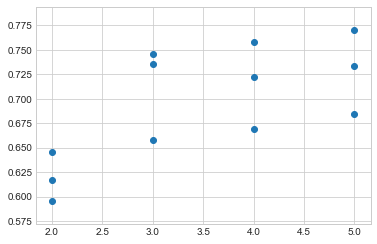

In [39]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','folds','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
cross_validation_list = np.arange(2,6)
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for cv in cross_validation_list:
        result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = cv)  
        result.append(cv)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['folds'],statistics['f1-score'])
selected_fold = statistics.sort_values(by=['f1-score'],ascending=False)['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### Experiment - KNN with HoldOut
Experiment using cross validation approach of HoldOut (Train test split)

,mae,mse,rmse,precision,accuracy,f1-score,test_size,type
21,0.170341,0.170341,0.412723,0.827930,0.829659,0.827576,0.4,Both
22,0.172972,0.172972,0.415899,0.825604,0.827028,0.825210,0.5,Both
23,0.173681,0.173681,0.416750,0.823801,0.826319,0.824080,0.6,Both
24,0.173938,0.173938,0.417059,0.823487,0.826062,0.823636,0.7,Both
25,0.177856,0.177856,0.421729,0.820781,0.822144,0.820273,0.8,Both
20,0.178466,0.178466,0.422453,0.819828,0.821534,0.819664,0.3,Both
19,0.181964,0.181964,0.426572,0.817341,0.818036,0.816455,0.2,Both
26,0.182401,0.182401,0.427084,0.816367,0.817599,0.814666,0.9,Both
18,0.185096,0.185096,0.430228,0.815065,0.814904,0.813292,0.1,Both
3,0.212425,0.212425,0.460896,0.784390,0.787575,0.784640,0.4,RSSI Only


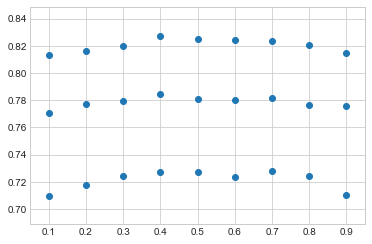

In [40]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','test_size','type']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for size in test_sizes:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = size, random_state = 42,stratify=train_Y)
        result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
        result.append(size)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['test_size'],statistics['f1-score'])

#### Experiment - KNN with Leave One Group Out 
Experiment using cross validation approach of Leave One Group Out

In [41]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
    result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))

,mae,mse,rmse,precision,accuracy,f1-score,type
0,1.0,1.0,1.0,0.0,0.0,0.0,RSSI Only
1,1.0,1.0,1.0,0.0,0.0,0.0,Rolling Mean RSSI
2,1.0,1.0,1.0,0.0,0.0,0.0,Both


#### Evaluation Model Cross-Validation Experiment - Best cross-validation technique
Best parameters found using RF

,mae,mse,rmse,precision,accuracy,f1-score,method,type
7,0.170341,0.170341,0.412723,0.827930,0.829659,0.827576,HoldOut,Both
1,0.212425,0.212425,0.460896,0.784390,0.787575,0.784640,HoldOut,RSSI Only
8,0.226453,0.226453,0.475871,0.769677,0.773547,0.770017,Stratified K-Fold,Both
2,0.262365,0.262365,0.512216,0.732199,0.737635,0.733224,Stratified K-Fold,RSSI Only
4,0.269138,0.269138,0.518785,0.726807,0.730862,0.727411,HoldOut,Rolling Mean RSSI
5,0.308617,0.308617,0.555533,0.682144,0.691383,0.684537,Stratified K-Fold,Rolling Mean RSSI
0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,RSSI Only
3,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,Rolling Mean RSSI
6,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,Both


Selected cross validation method:  HoldOut


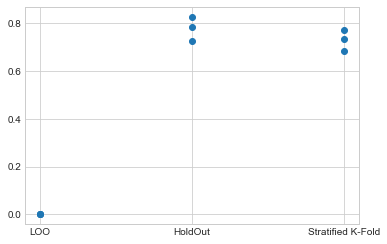

In [42]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','method','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.4, random_state = 42,stratify=train_Y)
    holdout = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
    loo = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    loo.append('LOO')
    loo.append(feature)
    results.append(loo)
    holdout.append('HoldOut')
    holdout.append(feature)
    results.append(holdout)
    skfold = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = selected_fold)
    skfold.append('Stratified K-Fold')
    skfold.append(feature)
    results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['method'],statistics['f1-score'],'o')
selected_method = statistics.sort_values(by=['f1-score'],ascending=False)['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

#### Experiment - Best preprocessing technique
Experiment with the different preprocessing techniques

,mae,mse,rmse,precision,accuracy,f1-score,preprocessing,preprocessingFunc,type
8,0.170341,0.170341,0.412723,0.827930,0.829659,0.827576,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Both
9,0.170341,0.170341,0.412723,0.827893,0.829659,0.827571,MaxAbsScaler,MaxAbsScaler(copy=True),Both
10,0.170341,0.170341,0.412723,0.827896,0.829659,0.827566,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Both
11,0.170541,0.170541,0.412966,0.827671,0.829459,0.827358,None,None,Both
0,0.212425,0.212425,0.460896,0.784390,0.787575,0.784640,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",RSSI Only
1,0.212425,0.212425,0.460896,0.784390,0.787575,0.784640,MaxAbsScaler,MaxAbsScaler(copy=True),RSSI Only
2,0.212425,0.212425,0.460896,0.784390,0.787575,0.784640,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",RSSI Only
3,0.212425,0.212425,0.460896,0.784390,0.787575,0.784640,None,None,RSSI Only
7,0.268938,0.268938,0.518592,0.726993,0.731062,0.727605,None,None,Rolling Mean RSSI
4,0.269138,0.269138,0.518785,0.726807,0.730862,0.727411,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Rolling Mean RSSI


Selected Preprocessing:  StandardScaler


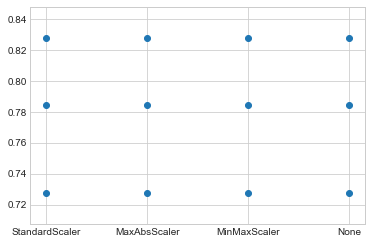

In [43]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','preprocessing','preprocessingFunc','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for preprocess in scaler:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = selected_fold)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.4, random_state = 42,stratify=train_Y)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=preprocess)
        if(preprocess is None):
            regex = 'None'
        else:
            regex = re.search('(\w+)\(',str(preprocess)).group(1)
        result.append(regex)
        result.append(preprocess)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['preprocessing'],statistics['f1-score'])
selected_preprocessing = statistics.sort_values(by=['f1-score'],ascending=False)['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['f1-score'],ascending=False)['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

#### Experiment - Running the RF function with the different number of decision trees

,mae,mse,rmse,precision,accuracy,f1-score,n_estimator,type
33,0.166333,0.166333,0.407839,0.832224,0.833667,0.831828,1600,Both
32,0.166934,0.166934,0.408575,0.831552,0.833066,0.831189,1400,Both
28,0.167535,0.167535,0.409310,0.830761,0.832465,0.830589,600,Both
35,0.167535,0.167535,0.409310,0.830818,0.832465,0.830572,2000,Both
34,0.167535,0.167535,0.409310,0.830818,0.832465,0.830572,1800,Both
30,0.167735,0.167735,0.409555,0.830487,0.832265,0.830368,1000,Both
27,0.168136,0.168136,0.410044,0.830476,0.831864,0.830065,400,Both
31,0.168136,0.168136,0.410044,0.830055,0.831864,0.829915,1200,Both
29,0.168537,0.168537,0.410533,0.829582,0.831463,0.829493,800,Both
26,0.169940,0.169940,0.412238,0.828505,0.830060,0.828096,200,Both


Selected Estimator Size:  1600


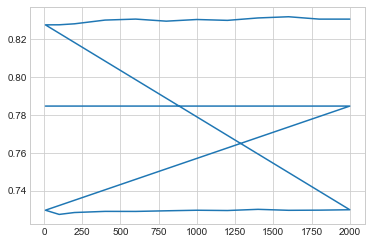

In [44]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','n_estimator','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for n in n_estimators:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(X_train,train_Y.ravel(),groups=train_Y.ravel())
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                n_estimators_parameter=n)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                 n_estimators_parameter=n)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.4,
                                                                                        random_state = 42,stratify=train_Y)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(), n_estimators_parameter=n)
        result.append(n)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['n_estimator'],statistics['f1-score'])
selected_estimator_size = statistics.sort_values(by=['f1-score'],ascending=False)['n_estimator'].head(1).values[0]
print("Selected Estimator Size: ",selected_estimator_size)

#### Experiment - Running the RF function with the different criterias

,mae,mse,rmse,precision,accuracy,f1-score,criterion,type
4,0.170341,0.170341,0.412723,0.827930,0.829659,0.827576,gini,Both
5,0.171543,0.171543,0.414178,0.826904,0.828457,0.826424,entropy,Both
0,0.212425,0.212425,0.460896,0.784390,0.787575,0.784640,gini,RSSI Only
1,0.212425,0.212425,0.460896,0.784390,0.787575,0.784640,entropy,RSSI Only
2,0.269138,0.269138,0.518785,0.726807,0.730862,0.727411,gini,Rolling Mean RSSI
3,0.269138,0.269138,0.518785,0.726807,0.730862,0.727411,entropy,Rolling Mean RSSI


Selected Criterion:  gini


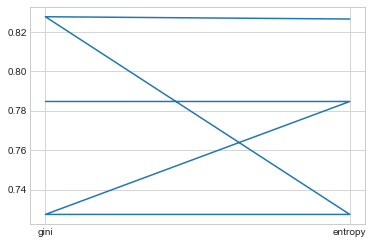

In [45]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','criterion','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for metric in criterion_metric:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(X_train,train_Y.ravel(),groups=train_Y.ravel())
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                criterion_parameter=metric)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                 criterion_parameter=metric)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.4,
                                                                                        random_state = 42,stratify=train_Y)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(), criterion_parameter=metric)
        result.append(metric)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['criterion'],statistics['f1-score'])
selected_criterion = statistics.sort_values(by=['f1-score'],ascending=False)['criterion'].head(1).values[0]
print("Selected Criterion: ",selected_criterion)

#### Experiment - Running the RF function with the different max_features 

,mae,mse,rmse,precision,accuracy,f1-score,max_feature,type
6,0.170341,0.170341,0.412723,0.827930,0.829659,0.827576,auto,Both
7,0.170341,0.170341,0.412723,0.827930,0.829659,0.827576,sqrt,Both
8,0.170341,0.170341,0.412723,0.827930,0.829659,0.827576,log2,Both
0,0.212425,0.212425,0.460896,0.784390,0.787575,0.784640,auto,RSSI Only
1,0.212425,0.212425,0.460896,0.784390,0.787575,0.784640,sqrt,RSSI Only
2,0.212425,0.212425,0.460896,0.784390,0.787575,0.784640,log2,RSSI Only
3,0.269138,0.269138,0.518785,0.726807,0.730862,0.727411,auto,Rolling Mean RSSI
4,0.269138,0.269138,0.518785,0.726807,0.730862,0.727411,sqrt,Rolling Mean RSSI
5,0.269138,0.269138,0.518785,0.726807,0.730862,0.727411,log2,Rolling Mean RSSI


Selected max_feature:  auto


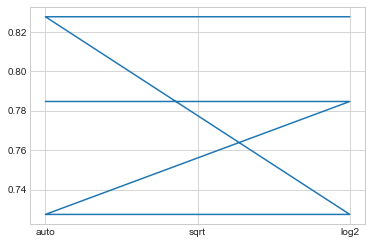

In [46]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','max_feature','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for max_feature in max_features:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(X_train,train_Y.ravel(),groups=train_Y.ravel())
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                max_features_parameter=max_feature)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                 max_features_parameter=max_feature)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.4,
                                                                                        random_state = 42,stratify=train_Y)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(), max_features_parameter=max_feature)
        result.append(max_feature)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['max_feature'],statistics['f1-score'])
selected_max_feature = statistics.sort_values(by=['f1-score'],ascending=False)['max_feature'].head(1).values[0]
print("Selected max_feature: ",selected_max_feature)

#### Experiment - Running the RF function with the different max_depth metric

,mae,mse,rmse,precision,accuracy,f1-score,max_depth,type
24,0.147495,0.147495,0.384051,0.851214,0.852505,0.850290,10.0,Both
25,0.168537,0.168537,0.410533,0.829696,0.831463,0.829375,20.0,Both
35,0.170341,0.170341,0.412723,0.827930,0.829659,0.827576,NaN,Both
34,0.170341,0.170341,0.412723,0.827930,0.829659,0.827576,110.0,Both
33,0.170341,0.170341,0.412723,0.827930,0.829659,0.827576,100.0,Both
32,0.170341,0.170341,0.412723,0.827930,0.829659,0.827576,90.0,Both
31,0.170341,0.170341,0.412723,0.827930,0.829659,0.827576,80.0,Both
30,0.170341,0.170341,0.412723,0.827930,0.829659,0.827576,70.0,Both
29,0.170341,0.170341,0.412723,0.827930,0.829659,0.827576,60.0,Both
28,0.170341,0.170341,0.412723,0.827930,0.829659,0.827576,50.0,Both


Selected max_depth:  10.0


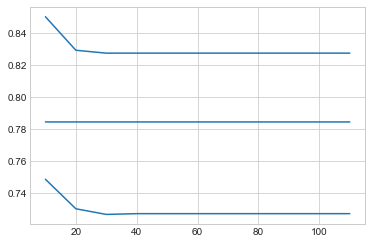

In [47]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','max_depth','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for depth in max_depth:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(X_train,train_Y.ravel(),groups=train_Y.ravel())
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                max_depth_parameter=depth)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                 max_depth_parameter=depth)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.4,
                                                                                        random_state = 42,stratify=train_Y)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(), max_depth_parameter=depth)
        result.append(depth)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['max_depth'],statistics['f1-score'])
selected_max_depth = statistics.sort_values(by=['f1-score'],ascending=False)['max_depth'].head(1).values[0]
print("Selected max_depth: ",selected_max_depth)

#### Experiment: Running the RF function with the different min_samples_split metric

,mae,mse,rmse,precision,accuracy,f1-score,min_samples_split,type
8,0.156112,0.156112,0.395110,0.842511,0.843888,0.842302,10,Both
7,0.163527,0.163527,0.404385,0.834789,0.836473,0.834522,5,Both
6,0.170341,0.170341,0.412723,0.827930,0.829659,0.827576,2,Both
0,0.212425,0.212425,0.460896,0.784390,0.787575,0.784640,2,RSSI Only
1,0.212425,0.212425,0.460896,0.784390,0.787575,0.784640,5,RSSI Only
2,0.212425,0.212425,0.460896,0.784390,0.787575,0.784640,10,RSSI Only
5,0.257315,0.257315,0.507262,0.738511,0.742685,0.739218,10,Rolling Mean RSSI
4,0.264930,0.264930,0.514713,0.730781,0.735070,0.731499,5,Rolling Mean RSSI
3,0.269138,0.269138,0.518785,0.726807,0.730862,0.727411,2,Rolling Mean RSSI


Selected min_samples_split:  10


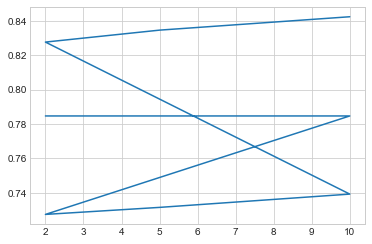

In [48]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','min_samples_split','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for s in min_samples_split:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(X_train,train_Y.ravel(),groups=train_Y.ravel())
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                min_samples_split_parameter=s)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                 min_samples_split_parameter=s)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.4,
                                                                                        random_state = 42,stratify=train_Y)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(), min_samples_split_parameter=s)
        result.append(s)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['min_samples_split'],statistics['f1-score'])
selected_min_samples_splith = statistics.sort_values(by=['f1-score'],ascending=False)['min_samples_split'].head(1).values[0]
print("Selected min_samples_split: ",selected_min_samples_splith)

#### 16th Experiment: Running the RF function with the different min_samples_leaf metric

,mae,mse,rmse,precision,accuracy,f1-score,min_samples_leaf,type
8,0.148096,0.148096,0.384833,0.851192,0.851904,0.850569,4,Both
7,0.157315,0.157315,0.396629,0.840862,0.842685,0.840787,2,Both
6,0.170341,0.170341,0.412723,0.827930,0.829659,0.827576,1,Both
0,0.212425,0.212425,0.460896,0.784390,0.787575,0.784640,1,RSSI Only
1,0.212425,0.212425,0.460896,0.784390,0.787575,0.784640,2,RSSI Only
2,0.212425,0.212425,0.460896,0.784390,0.787575,0.784640,4,RSSI Only
5,0.250301,0.250301,0.500301,0.744263,0.749699,0.745444,4,Rolling Mean RSSI
4,0.254709,0.254709,0.504687,0.741352,0.745291,0.741960,2,Rolling Mean RSSI
3,0.269138,0.269138,0.518785,0.726807,0.730862,0.727411,1,Rolling Mean RSSI


Selected min_samples_leaf:  4


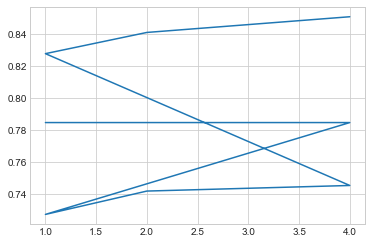

In [49]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','min_samples_leaf','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    for leaf in min_samples_leaf:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(X_train,train_Y.ravel(),groups=train_Y.ravel())
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                min_samples_leaf_parameter=leaf)  
        elif selected_method =='Stratified K-Fold':
            result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                                 cross_validation = selected_fold,
                                 min_samples_leaf_parameter=leaf)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.4,
                                                                                        random_state = 42,stratify=train_Y)
            result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                 scaler=StandardScaler(), min_samples_leaf_parameter=leaf)
        result.append(leaf)
        result.append(scannedType)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['min_samples_leaf'],statistics['f1-score'])
selected_min_samples_leaf = statistics.sort_values(by=['f1-score'],ascending=False)['min_samples_leaf'].head(1).values[0]
print("Selected min_samples_leaf: ",selected_min_samples_leaf)

### Run RandomizedSearchCV for parameter tunning

In [50]:
results = list()
scores = ['f1_macro']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    for feature in types:
        #Decide on type of data
        if feature == 'RSSI Only':
            trainX_data = train_X_rssi
        elif feature == 'Rolling Mean RSSI':
            trainX_data = train_X_rolling_mean
        else:
            trainX_data = combination_features_X 
        pipe = Pipeline([('standardizer', StandardScaler()), ('rf', RandomForestClassifier())])
        clf = RandomizedSearchCV(
           pipe, param_distributions = random_grid, n_iter = 50, cv=selected_fold,scoring=score,n_jobs=-1,verbose=1
        )
        clf.fit(trainX_data,train_Y.ravel())
        clf.best_params_['score'] = score
        clf.best_params_['best_score'] = clf.best_score_
        clf.best_params_['type'] = feature
        results.append(clf.best_params_)
gridcv_results = pd.DataFrame(results).sort_values(by=['best_score'],ascending=False)
display(gridcv_results)

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 10.8min finished


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  8.0min finished


,rf__n_estimators,rf__min_samples_split,rf__min_samples_leaf,rf__max_features,rf__max_depth,rf__criterion,rf__bootstrap,score,best_score,type
2,1200,10,4,sqrt,50.0,gini,True,f1_macro,0.784188,Both
0,10,2,2,auto,NaN,entropy,True,f1_macro,0.739448,RSSI Only
1,1600,2,2,sqrt,NaN,gini,True,f1_macro,0.682651,Rolling Mean RSSI


### Best Parameters
Display the best parameters tunned throughout the experiments

In [51]:
conclusion_cols=['Cross_Validation','Number of Estimators','Max Features','Max Depth','Criterion','Min_Samples_Leaf','Min_Samples_Split','Preprocessing']
conclusion_list = [selected_method,selected_estimator_size,selected_max_feature,selected_max_depth,selected_criterion,
                   selected_min_samples_leaf,selected_min_samples_splith,selected_preprocessing]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

,Cross_Validation,Number of Estimators,Max Features,Max Depth,Criterion,Min_Samples_Leaf,Min_Samples_Split,Preprocessing
0,HoldOut,1600,auto,10.0,gini,4,10,StandardScaler


### Best Results
Compute RF with the best parameters tuned by RandomGridSearchCV and manually tuned

In [52]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
criterion = selected_criterion
estimators = selected_estimator_size
depth = selected_max_depth
max_feat = selected_max_feature
min_samples_split = selected_min_samples_splith
min_samples_leaf = selected_min_samples_leaf
for scannedType in types:
    if scannedType == 'RSSI Only':
        trainX_data = train_X_rssi
    elif scannedType == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(X_train,train_Y.ravel(),groups=train_Y.ravel())
        result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                            n_estimators_parameter=estimators,criterion_parameter=criterion,
                                          max_depth_parameter=depth, max_features_parameter=max_feat,
                                          min_samples_leaf_parameter=min_samples_leaf,
                                          min_samples_split_parameter=min_samples_split)  
    elif selected_method =='Stratified K-Fold':
        result = compute_RF_Classification(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                             cross_validation = selected_fold,
                            n_estimators_parameter=estimators,criterion_parameter=criterion,
                                          max_depth_parameter=depth, max_features_parameter=max_feat,
                                          min_samples_leaf_parameter=min_samples_leaf,
                                          min_samples_split_parameter=min_samples_split) 
    else:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.4,
                                                                                    random_state = 42,stratify=train_Y)
        result = compute_RF_Classification(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                             scaler=StandardScaler(),n_estimators_parameter=estimators,criterion_parameter=criterion,
                                          max_depth_parameter=depth, max_features_parameter=max_feat,
                                          min_samples_leaf_parameter=min_samples_leaf,
                                          min_samples_split_parameter=min_samples_split) 
    result.append(scannedType)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending = False))

,mae,mse,rmse,precision,accuracy,f1-score,type
2,0.144890,0.144890,0.380644,0.853945,0.855110,0.852910,Both
0,0.212425,0.212425,0.460896,0.784390,0.787575,0.784640,RSSI Only
1,0.234469,0.234469,0.484220,0.758582,0.765531,0.758527,Rolling Mean RSSI


### Best Results - Testing data (using data recovered from Android 6.0 Asus ZENFONE Live)
Experiment with testing dataset

Confusion Matrix:
[[50 53  0  0]
 [ 0 36 32 37]
 [ 0 17 34 54]
 [ 0  0 39 63]]


,precision,recall,f1-score,support
0,1.000000,0.485437,0.653595,103.000000
1,0.339623,0.342857,0.341232,105.000000
2,0.323810,0.323810,0.323810,105.000000
3,0.409091,0.617647,0.492187,102.000000
accuracy,0.440964,0.440964,0.440964,0.440964
macro avg,0.518131,0.442438,0.452706,415.000000
weighted avg,0.516597,0.440964,0.451452,415.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
410,3,3
411,3,3
412,3,3
413,3,2


Confusion Matrix:
[[  0   0   0 103]
 [  0   0   0 105]
 [  0   0   0 105]
 [  0   0   0 102]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,103.000000
1,0.000000,0.000000,0.000000,105.000000
2,0.000000,0.000000,0.000000,105.000000
3,0.245783,1.000000,0.394584,102.000000
accuracy,0.245783,0.245783,0.245783,0.245783
macro avg,0.061446,0.250000,0.098646,415.000000
weighted avg,0.060409,0.245783,0.096982,415.000000


,Actual,Predicted
0,0,3
1,0,3
2,0,3
3,0,3
4,0,3
...,...,...
410,3,3
411,3,3
412,3,3
413,3,3


Confusion Matrix:
[[50 53  0  0]
 [ 0 32 40 33]
 [ 0 12 40 53]
 [ 0  0 22 80]]


,precision,recall,f1-score,support
0,1.000000,0.485437,0.653595,103.000000
1,0.329897,0.304762,0.316832,105.000000
2,0.392157,0.380952,0.386473,105.000000
3,0.481928,0.784314,0.597015,102.000000
accuracy,0.486747,0.486747,0.486747,0.486747
macro avg,0.550995,0.488866,0.488479,415.000000
weighted avg,0.549331,0.486747,0.486898,415.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
410,3,3
411,3,3
412,3,3
413,3,3


Confusion Matrix:
[[  0   0   0 103]
 [  0   0   0 105]
 [  0   0   0 105]
 [  0   0   0 102]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,103.000000
1,0.000000,0.000000,0.000000,105.000000
2,0.000000,0.000000,0.000000,105.000000
3,0.245783,1.000000,0.394584,102.000000
accuracy,0.245783,0.245783,0.245783,0.245783
macro avg,0.061446,0.250000,0.098646,415.000000
weighted avg,0.060409,0.245783,0.096982,415.000000


,Actual,Predicted
0,0,3
1,0,3
2,0,3
3,0,3
4,0,3
...,...,...
410,3,3
411,3,3
412,3,3
413,3,3


Confusion Matrix:
[[50 53  0  0]
 [ 0 31 30 44]
 [ 0  9 36 60]
 [ 0  2 39 61]]


,precision,recall,f1-score,support
0,1.000000,0.485437,0.653595,103.000000
1,0.326316,0.295238,0.310000,105.000000
2,0.342857,0.342857,0.342857,105.000000
3,0.369697,0.598039,0.456929,102.000000
accuracy,0.428916,0.428916,0.428916,0.428916
macro avg,0.509717,0.430393,0.440845,415.000000
weighted avg,0.508367,0.428916,0.439704,415.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
410,3,3
411,3,3
412,3,3
413,3,3


Confusion Matrix:
[[  0   0   0 103]
 [  0   0   0 105]
 [  0   0   0 105]
 [  0   0   0 102]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,103.000000
1,0.000000,0.000000,0.000000,105.000000
2,0.000000,0.000000,0.000000,105.000000
3,0.245783,1.000000,0.394584,102.000000
accuracy,0.245783,0.245783,0.245783,0.245783
macro avg,0.061446,0.250000,0.098646,415.000000
weighted avg,0.060409,0.245783,0.096982,415.000000


,Actual,Predicted
0,0,3
1,0,3
2,0,3
3,0,3
4,0,3
...,...,...
410,3,3
411,3,3
412,3,3
413,3,3


,mae,mse,rmse,precision,accuracy,f1-score,type,Tuning
2,0.513253,0.513253,0.716417,0.541579,0.486747,0.488006,Rolling Mean RSSI,True
0,0.559036,0.559036,0.747687,0.506888,0.440964,0.450849,RSSI Only,True
4,0.571084,0.571084,0.755701,0.497981,0.428916,0.438978,Both,True
1,0.754217,0.754217,0.868457,0.087632,0.245783,0.119428,RSSI Only,False
3,0.754217,0.754217,0.868457,0.087632,0.245783,0.119428,Rolling Mean RSSI,False
5,0.754217,0.754217,0.868457,0.087632,0.245783,0.119428,Both,False


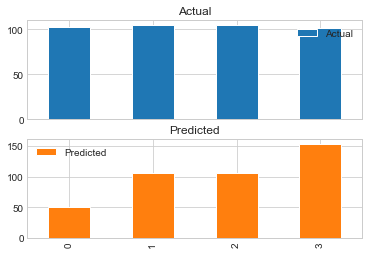

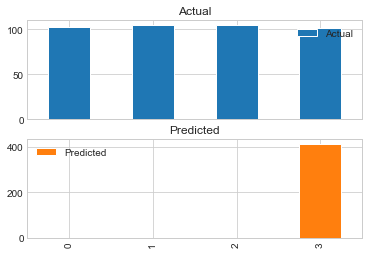

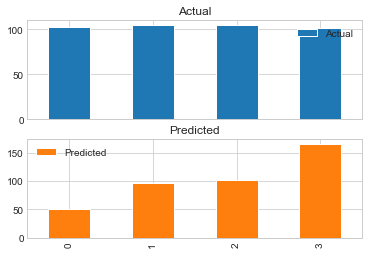

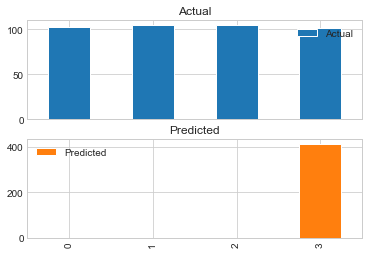

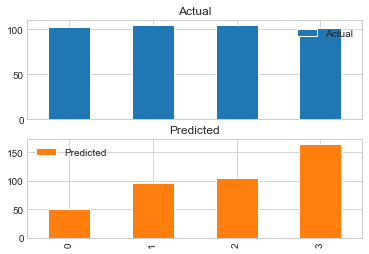

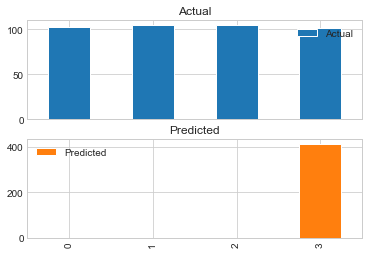

In [53]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
criterion = selected_criterion
estimators = selected_estimator_size
depth = selected_max_depth
max_feat = selected_max_feature
min_samples_split = selected_min_samples_splith
min_samples_leaf = selected_min_samples_leaf
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X 
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    for tune in tuning:
        if tune == True:
            model = RandomForestClassifier(n_estimators=estimators,criterion=criterion,
                                                    max_features=max_feat,max_depth=depth,
                                                    min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split)  
        else: 
            model = RandomForestClassifier()
        trainX_data = scaler.transform(trainX_data)
        model.fit(trainX_data,train_Y.ravel())
        predicted = model.predict(testX_data)
        matrix = confusion_matrix(test_Y.ravel(), predicted)
        report = classification_report(test_Y.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))

### Best Results - Testing data (using data recovered from Android 10 SAMSUNG Galaxy A71)
Experiment with testing dataset

Confusion Matrix:
[[490  44  20  18]
 [  0 255 139 178]
 [  0 376 118  80]
 [  0   7 202 357]]


,precision,recall,f1-score,support
0,1.000000,0.856643,0.922787,572.000000
1,0.373900,0.445804,0.406699,572.000000
2,0.246347,0.205575,0.224122,574.000000
3,0.563981,0.630742,0.595496,566.000000
accuracy,0.534151,0.534151,0.534151,0.534151
macro avg,0.546057,0.534691,0.537276,2284.000000
weighted avg,0.545747,0.534151,0.536849,2284.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2279,3,3
2280,3,3
2281,3,3
2282,3,2


Confusion Matrix:
[[  0   0   0 572]
 [  0   0   0 572]
 [  0   0   0 574]
 [  0   0   0 566]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,572.000000
1,0.000000,0.000000,0.000000,572.000000
2,0.000000,0.000000,0.000000,574.000000
3,0.247811,1.000000,0.397193,566.000000
accuracy,0.247811,0.247811,0.247811,0.247811
macro avg,0.061953,0.250000,0.099298,2284.000000
weighted avg,0.061410,0.247811,0.098429,2284.000000


,Actual,Predicted
0,0,3
1,0,3
2,0,3
3,0,3
4,0,3
...,...,...
2279,3,3
2280,3,3
2281,3,3
2282,3,3


Confusion Matrix:
[[485  43  27  17]
 [  0 203 165 204]
 [  0 329 119 126]
 [  0   7 112 447]]


,precision,recall,f1-score,support
0,1.000000,0.847902,0.917692,572.000000
1,0.348797,0.354895,0.351820,572.000000
2,0.281324,0.207317,0.238716,574.000000
3,0.562972,0.789753,0.657353,566.000000
accuracy,0.549037,0.549037,0.549037,0.549037
macro avg,0.548273,0.549967,0.541395,2284.000000
weighted avg,0.548001,0.549037,0.540825,2284.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2279,3,3
2280,3,3
2281,3,3
2282,3,3


Confusion Matrix:
[[  0   0   0 572]
 [  0   0   0 572]
 [  0   0   0 574]
 [  0   0   0 566]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,572.000000
1,0.000000,0.000000,0.000000,572.000000
2,0.000000,0.000000,0.000000,574.000000
3,0.247811,1.000000,0.397193,566.000000
accuracy,0.247811,0.247811,0.247811,0.247811
macro avg,0.061953,0.250000,0.099298,2284.000000
weighted avg,0.061410,0.247811,0.098429,2284.000000


,Actual,Predicted
0,0,3
1,0,3
2,0,3
3,0,3
4,0,3
...,...,...
2279,3,3
2280,3,3
2281,3,3
2282,3,3


Confusion Matrix:
[[493  38  22  19]
 [  0 188 140 244]
 [  0 306 107 161]
 [  0   4 193 369]]


,precision,recall,f1-score,support
0,1.000000,0.861888,0.925822,572.000000
1,0.350746,0.328671,0.339350,572.000000
2,0.231602,0.186411,0.206564,574.000000
3,0.465322,0.651943,0.543046,566.000000
accuracy,0.506567,0.506567,0.506567,0.506567
macro avg,0.511917,0.507229,0.503695,2284.000000
weighted avg,0.511794,0.506567,0.503332,2284.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2279,3,3
2280,3,3
2281,3,3
2282,3,2


Confusion Matrix:
[[  0   0   0 572]
 [  0   0   0 572]
 [  0   0   0 574]
 [  0   0   0 566]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,572.000000
1,0.000000,0.000000,0.000000,572.000000
2,0.000000,0.000000,0.000000,574.000000
3,0.247811,1.000000,0.397193,566.000000
accuracy,0.247811,0.247811,0.247811,0.247811
macro avg,0.061953,0.250000,0.099298,2284.000000
weighted avg,0.061410,0.247811,0.098429,2284.000000


,Actual,Predicted
0,0,3
1,0,3
2,0,3
3,0,3
4,0,3
...,...,...
2279,3,3
2280,3,3
2281,3,3
2282,3,3


,mae,mse,rmse,precision,accuracy,f1-score,type,Tuning
2,0.450963,0.450963,0.671538,0.548344,0.549037,0.542405,Rolling Mean RSSI,True
0,0.465849,0.465849,0.682532,0.544312,0.534151,0.536768,RSSI Only,True
4,0.493433,0.493433,0.702448,0.511136,0.506567,0.504054,Both,True
1,0.752189,0.752189,0.867288,0.088426,0.247811,0.120390,RSSI Only,False
3,0.752189,0.752189,0.867288,0.088426,0.247811,0.120390,Rolling Mean RSSI,False
5,0.752189,0.752189,0.867288,0.088426,0.247811,0.120390,Both,False


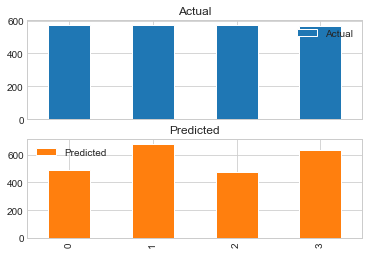

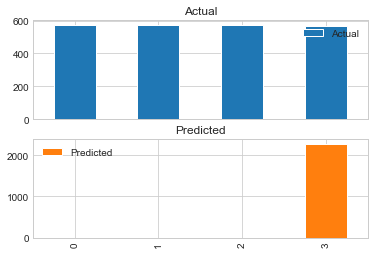

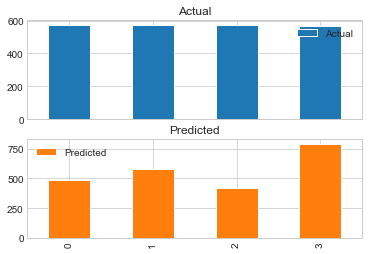

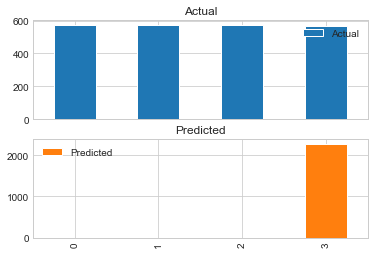

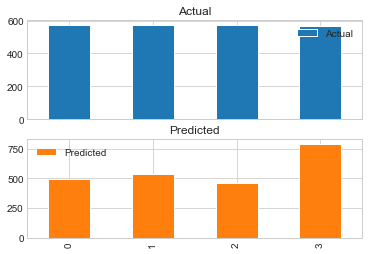

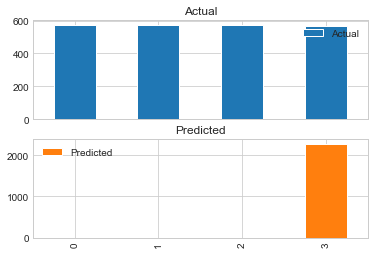

In [54]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
criterion = selected_criterion
estimators = selected_estimator_size
depth = selected_max_depth
max_feat = selected_max_feature
min_samples_split = selected_min_samples_splith
min_samples_leaf = selected_min_samples_leaf
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi_my_device
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean_my_device
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X_my_device 
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    for tune in tuning:
        if tune == True:
            model = RandomForestClassifier(n_estimators=estimators,criterion=criterion,
                                                    max_features=max_feat,max_depth=depth,
                                                    min_samples_leaf=min_samples_leaf,min_samples_split=min_samples_split)  
        else: 
            model = RandomForestClassifier()
        trainX_data = scaler.transform(trainX_data)
        model.fit(trainX_data,train_Y.ravel())
        predicted = model.predict(testX_data)
        matrix = confusion_matrix(test_Y_my_device.ravel(), predicted)
        report = classification_report(test_Y_my_device.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y_my_device.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y_my_device.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))